In [1]:
import pandas as pd
import scipy as scp
import feather
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
scp.__version__, pd.__version__

('0.19.1', '0.20.3')

In [3]:
labeled_train = pd.concat([feather.read_dataframe('digits-train.feather'), 
                           feather.read_dataframe('digits-train-labels.feather')],
                           axis = 1)

In [4]:
labeled_test = pd.concat([feather.read_dataframe('digits-test.feather'), 
                          feather.read_dataframe('digits-test-labels.feather')],
                          axis = 1)

In [5]:
def binary_representation(label, target_label) :
    if (label == target_label) : return 1
    else : return -1

In [6]:
def choose_digits(labeled_digits, labels) :
    chosen = labeled_digits.loc[labeled_digits.label.isin(labels), :].copy()
    chosen.label = chosen.label.apply(lambda x : binary_representation(x, labels[0]))
    return chosen

In [7]:
def validation_split(labeled_train, frac, seed) :
    n = round(len(labeled_train) * frac)
    labeled_val = labeled_train.sample(n, axis = 0, random_state = seed, replace = False)
    labeled_train = labeled_train.loc[~labeled_train.index.isin(labeled_val.index), :]
    return labeled_train, labeled_val

In [8]:
def values_label_split(labeled_values) :
    labels = labeled_values.label.values
    values = labeled_values.drop('label', axis = 1).values
    return values, labels

In [9]:
def distances(train_values, test_value) :
    
    x = train_values - test_value
    y = (x * x).sum(axis = 1)
    
    return y

In [10]:
def predict(train_values, train_labels, test_value) :
    
    dist = distances(train_values, test_value)
    idx = scp.argsort(dist)
    neighbour_sorted_labels = train_labels[idx]
    predictions = scp.sign(scp.cumsum(neighbour_sorted_labels))
    
    return predictions
    

In [11]:
def predict_all(train_values, train_labels, test_values) :

    result = [predict(train_values, train_labels, test_value) for test_value in test_values]
    result = pd.DataFrame(result)
    result.replace(0, scp.nan)
    
    return result

In [12]:
def find_errors(predictions, test_labels) :
    return predictions.apply(lambda col : abs(col - test_labels)/2, axis = 0)

In [13]:
def find_accuracy(errors) :
    return 1 - errors.mean(axis = 0)

In [14]:
def max_stats(accuracies, score_type, q) :
    max_acc = accuracies[score_type].max()
    ks = accuracies.loc[accuracies[score_type] == max_acc, 'K'].values
    k = int(scp.percentile(ks, q))
    return {'max_acc': max_acc, 'ks': ks, 'k': k}

In [15]:
def nearest_neighbours(labeled_train, labeled_test, target_labels, val_frac = 0.2, seed = 1989, choose_k_q = 50) :
    
    labeled_train = choose_digits(labeled_train, target_labels)
    labeled_test = choose_digits(labeled_test, target_labels)
    labeled_train, labeled_val = validation_split(labeled_train, val_frac, seed)
    
    train_values, train_labels = values_label_split(labeled_train)
    test_values, test_labels = values_label_split(labeled_test)
    val_values, val_labels = values_label_split(labeled_val)
    
    val_predictions = predict_all(train_values, train_labels, val_values)
    test_predictions = predict_all(train_values, train_labels, test_values)
    
    val_errors = find_errors(val_predictions, val_labels)
    test_errors = find_errors(test_predictions, test_labels)
    
    val_accuracies = find_accuracy(val_errors)
    test_accuracies = find_accuracy(test_errors)
    
    n = max(len(val_accuracies), len(test_accuracies))
    
    accuracies = pd.DataFrame({'K':range(1, n + 1),
                               'validation_score': val_accuracies[0: n],
                               'test_score': test_accuracies[0: n]})
    
    val_max_stats = max_stats(accuracies, 'validation_score', choose_k_q)
    test_max_stats = max_stats(accuracies, 'test_score', choose_k_q)
    
    return {'target_labels' : target_labels,
            'acc' : accuracies, 
            'validation_score_stats' : val_max_stats,
            'test_score_stats' : test_max_stats,
            'val_pred' : val_predictions,
            'test_pred' : test_predictions,
            'val_values' : val_values,
            'test_values' : test_values,
            'val_labels' : val_labels,
            'test_labels' : test_labels }
    

In [16]:
def run_experiment(labeled_train, labeled_test, target_labels_list, val_frac = 0.2, seed = 1989) :
    
    return [nearest_neighbours(labeled_train, labeled_test, target_labels, val_frac, seed) for target_labels in target_labels_list]

In [17]:
%time results = run_experiment(labeled_train, labeled_test, [[0,1],[0,8],[5,6]])

CPU times: user 23.8 s, sys: 92 ms, total: 23.8 s
Wall time: 23.9 s


In [18]:
def make_plots(result, ks, loc, figsize = (18,4)) : 
    
    fig, axs = plt.subplots(1, len(ks), sharey = True, figsize = figsize)
    target_labels = result['target_labels']
    fig.suptitle('Chosen digits: ' + str(target_labels), fontsize = 20)
    
    colormap = {'validation_score': 'royalblue', 'test_score': 'tomato'}
    
    acc = result['acc']
    
    for i in range(0, len(ks)) :
        
        ax = axs[i]
        k = ks[i]
        
        for score in ['validation_score', 'test_score'] :
        
            ax.plot(acc.K[0:k], acc[score][0:k], label = score, color = colormap[score])
    
    ylim = axs[len(ks) - 1].get_ylim()
    
    for ax in axs :
        
        xlim = ax.get_xlim()
        
        for score in ['validation_score', 'test_score'] :
            
            max_stats = result[score + '_stats']
            chosen_k = max_stats['k']
            max_acc = max_stats['max_acc']
            if (chosen_k < xlim[1]) :
                ax.vlines(chosen_k, ymin = ylim[0], ymax = ylim[1], color = colormap[score], linestyles = 'dashed')

    for ax in axs :
        ax.legend(fontsize = 'large', loc = loc)
        ax.set_xlabel('K', fontsize = 'x-large')
    
    axs[0].set_ylabel('score', fontsize = 'x-large')
    
    fig.savefig('digits_' + str(target_labels[0]) + '_' + str(target_labels[1]) + '.jpg')
    
    return

In [19]:
def make_all_plots(results, ks, loc) :
    
    for result in results :
        
        make_plots(result, ks, loc)
    
    return

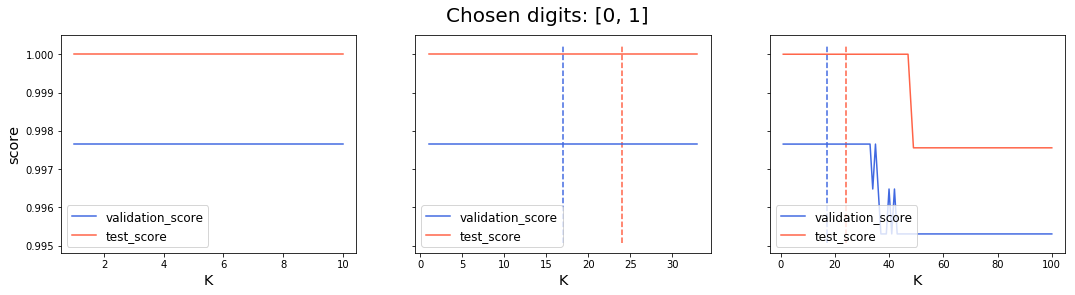

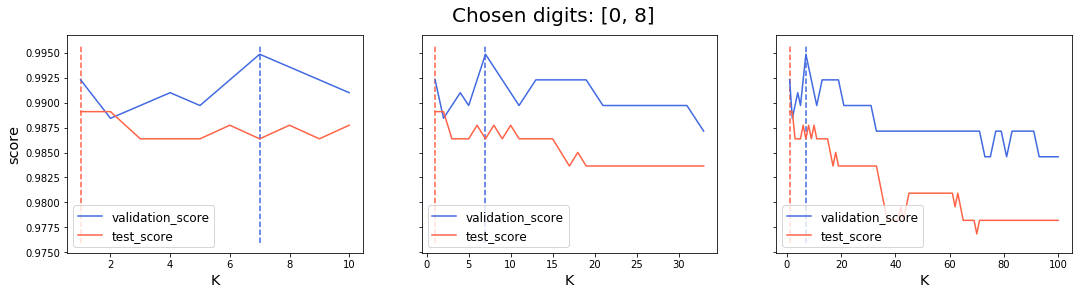

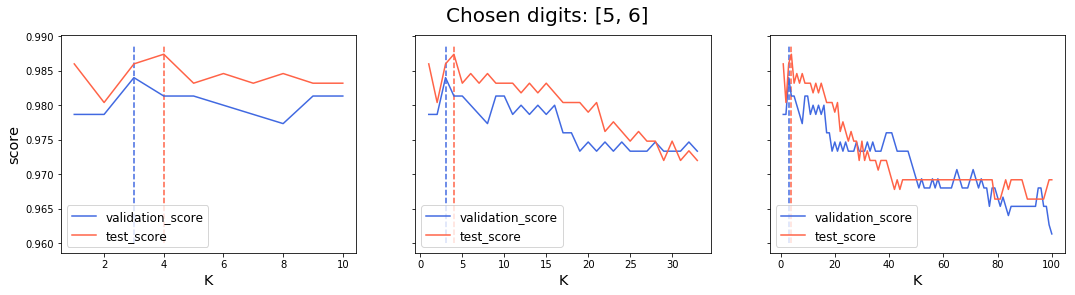

In [20]:
make_all_plots(results, [10, 33,100], 'lower left')